## PRODUCING BLURR DATASETS

In [2]:
import os
from PIL import Image, ImageFilter
from tqdm import tqdm

# Paths
input_dir = "DIV2K\DIV2K_train_HR\DIV2K_train_HR"
output_dir = "DIV2K\DIV2K_train_HR\DIV2K_train_blur"

# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Loop through images and apply blur
for filename in tqdm(sorted(os.listdir(input_dir))):
    if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
        input_path = os.path.join(input_dir, filename)
        output_path = os.path.join(output_dir, filename)

        # Load image and apply Gaussian blur
        image = Image.open(input_path).convert("RGB")
        blurred = image.filter(ImageFilter.GaussianBlur(radius=1))  # Adjust radius as needed

        # Save the blurred image
        blurred.save(output_path)

print("✅ Finished generating blurred images.")

<>:6: SyntaxWarning: invalid escape sequence '\D'
<>:7: SyntaxWarning: invalid escape sequence '\D'
<>:6: SyntaxWarning: invalid escape sequence '\D'
<>:7: SyntaxWarning: invalid escape sequence '\D'
C:\Users\sreej\AppData\Local\Temp\ipykernel_13436\2870842936.py:6: SyntaxWarning: invalid escape sequence '\D'
  input_dir = "DIV2K\DIV2K_train_HR\DIV2K_train_HR"
C:\Users\sreej\AppData\Local\Temp\ipykernel_13436\2870842936.py:7: SyntaxWarning: invalid escape sequence '\D'
  output_dir = "DIV2K\DIV2K_train_HR\DIV2K_train_blur"
100%|██████████| 800/800 [29:24<00:00,  2.21s/it]

✅ Finished generating blurred images.


In [4]:
import os
from PIL import Image, ImageFilter
from tqdm import tqdm

# Paths
input_dir = "DIV2K\DIV2K_valid_HR\DIV2K_valid_HR"
output_dir = "DIV2K\DIV2K_valid_HR\DIV2K_valid_blur"

# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Loop through images and apply blur
for filename in tqdm(sorted(os.listdir(input_dir))):
    if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
        input_path = os.path.join(input_dir, filename)
        output_path = os.path.join(output_dir, filename)

        # Load image and apply Gaussian blur
        image = Image.open(input_path).convert("RGB")
        blurred = image.filter(ImageFilter.GaussianBlur(radius=1))  # Adjust radius as needed

        # Save the blurred image
        blurred.save(output_path)

print("✅ Finished generating blurred images.")

<>:6: SyntaxWarning: invalid escape sequence '\D'
<>:7: SyntaxWarning: invalid escape sequence '\D'
<>:6: SyntaxWarning: invalid escape sequence '\D'
<>:7: SyntaxWarning: invalid escape sequence '\D'
C:\Users\sreej\AppData\Local\Temp\ipykernel_13436\3209675501.py:6: SyntaxWarning: invalid escape sequence '\D'
  input_dir = "DIV2K\DIV2K_valid_HR\DIV2K_valid_HR"
C:\Users\sreej\AppData\Local\Temp\ipykernel_13436\3209675501.py:7: SyntaxWarning: invalid escape sequence '\D'
  output_dir = "DIV2K\DIV2K_valid_HR\DIV2K_valid_blur"
100%|██████████| 100/100 [03:39<00:00,  2.20s/it]

✅ Finished generating blurred images.


## TEACHER EVALUATION

In [1]:
import os
import sys
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import numpy as np
from PIL import Image, ImageOps
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

# ----------------------------------------
# Import Restormer Architecture
# ----------------------------------------
sys.path.append(os.path.abspath('./Restormer/basicsr/models/archs'))
from restormer_arch import Restormer

# ----------------------------------------
# Dataset Class
# ----------------------------------------
class DeblurDataset(Dataset):
    def __init__(self, blur_dir, sharp_dir, transform):
        self.blur_dir = blur_dir
        self.sharp_dir = sharp_dir
        self.transform = transform

        blur_files = sorted(os.listdir(blur_dir))
        sharp_files = sorted(os.listdir(sharp_dir))

        self.pairs = []
        for b in blur_files:
            base = b.split('_')[0]
            sharp_match = next((s for s in sharp_files if s.startswith(base)), None)
            if sharp_match:
                self.pairs.append((b, sharp_match))

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        blur_name, sharp_name = self.pairs[idx]
        blur_path = os.path.join(self.blur_dir, blur_name)
        sharp_path = os.path.join(self.sharp_dir, sharp_name)

        blur = ImageOps.exif_transpose(Image.open(blur_path).convert("RGB"))
        sharp = ImageOps.exif_transpose(Image.open(sharp_path).convert("RGB"))

        if self.transform:
            blur = self.transform(blur)
            sharp = self.transform(sharp)

        return blur, sharp

# ----------------------------------------
# Evaluation Function
# ----------------------------------------
def evaluate(model, dataloader, device):
    model.eval()
    psnr_scores = []
    ssim_scores = []

    with torch.no_grad():
        for blur, sharp in dataloader:
            blur, sharp = blur.to(device), sharp.to(device)
            output = model(blur)

            # Prepare for metric computation
            output_np = output.squeeze().cpu().permute(1, 2, 0).clamp(0, 1).numpy()
            sharp_np = sharp.squeeze().cpu().permute(1, 2, 0).clamp(0, 1).numpy()

            psnr_val = psnr(sharp_np, output_np, data_range=1.0)
            ssim_val = ssim(sharp_np, output_np, data_range=1.0, channel_axis=-1)

            psnr_scores.append(psnr_val)
            ssim_scores.append(ssim_val)

    print(f"\n📈 Average PSNR: {np.mean(psnr_scores):.2f} dB")
    print(f"📊 Average SSIM: {np.mean(ssim_scores):.4f}")

# ----------------------------------------
# Main Execution
# ----------------------------------------
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"🚀 Running evaluation on device: {device}")

    model = Restormer(
        inp_channels=3, out_channels=3, dim=48,
        num_blocks=[4, 6, 6, 8], num_refinement_blocks=4,
        heads=[1, 2, 4, 8], ffn_expansion_factor=2.66,
        bias=False, LayerNorm_type='WithBias', dual_pixel_task=False
    ).to(device)

    ckpt = torch.load("single_image_defocus_deblurring.pth", map_location=device)
    model.load_state_dict(ckpt["params"])
    print("✅ Loaded teacher Restormer model.")

    transform = transforms.Compose([
        transforms.Resize((128, 128)),  # Optional: can skip this for full-res
        transforms.ToTensor()
    ])

    dataset = DeblurDataset(
        "DIV2K/DIV2K_train_HR/DIV2K_train_blur",
        "DIV2K/DIV2K_train_HR/DIV2K_train_HR",
        transform
    )

    dataloader = DataLoader(dataset, batch_size=1, shuffle=False, num_workers=0)
    evaluate(model, dataloader, device)

c:\Users\sreej\anaconda3\Lib\site-packages\paramiko\pkey.py:82: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "cipher": algorithms.TripleDES,
c:\Users\sreej\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.Blowfish and will be removed from this module in 45.0.0.
  "class": algorithms.Blowfish,
c:\Users\sreej\anaconda3\Lib\site-packages\paramiko\transport.py:243: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "class": algorithms.TripleDES,


🚀 Running evaluation on device: cpu
✅ Loaded teacher Restormer model.

📈 Average PSNR: 28.17 dB
📊 Average SSIM: 0.9305


## STUDENT MODEL

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms, models
from tqdm import tqdm
import os
import sys
from PIL import Image, ImageOps
import numpy as np
from skimage.metrics import structural_similarity as ssim, peak_signal_noise_ratio as psnr
from pytorch_msssim import ssim as ssim_loss_fn  # pip install pytorch-msssim

# ------------------------------
# Student Model (Simple SRCNN)
# ------------------------------
class StudentSRCNN(nn.Module):
    def __init__(self):
        super(StudentSRCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=9, padding=4)
        self.conv2 = nn.Conv2d(64, 32, kernel_size=5, padding=2)
        self.conv3 = nn.Conv2d(32, 3, kernel_size=5, padding=2)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        return self.conv3(x)

# ------------------------------
# Perceptual Loss Using VGG
# ------------------------------
class VGGPerceptualLoss(nn.Module):
    def __init__(self):
        super(VGGPerceptualLoss, self).__init__()
        vgg = models.vgg16(pretrained=True).features[:16].eval()
        for param in vgg.parameters():
            param.requires_grad = False
        self.vgg = vgg
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                              std=[0.229, 0.224, 0.225])

    def forward(self, x, y):
        x = nn.functional.interpolate(x, size=(224, 224), mode='bilinear', align_corners=False)
        y = nn.functional.interpolate(y, size=(224, 224), mode='bilinear', align_corners=False)
        x, y = self.normalize(x), self.normalize(y)
        return nn.functional.mse_loss(self.vgg(x), self.vgg(y))

# ------------------------------
# Custom Dataset
# ------------------------------
class DeblurDataset(torch.utils.data.Dataset):
    def __init__(self, blur_dir, sharp_dir, transform):
        self.blur_dir = blur_dir
        self.sharp_dir = sharp_dir
        self.transform = transform

        blur_files = sorted(os.listdir(blur_dir))
        sharp_files = sorted(os.listdir(sharp_dir))

        self.pairs = []
        for b in blur_files:
            base = b.split('_')[0]
            sharp_match = next((s for s in sharp_files if s.startswith(base)), None)
            if sharp_match:
                self.pairs.append((b, sharp_match))
            else:
                print(f"⚠️ Skipping unmatched file: {b}")

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        blur_name, sharp_name = self.pairs[idx]
        blur_path = os.path.join(self.blur_dir, blur_name)
        sharp_path = os.path.join(self.sharp_dir, sharp_name)

        try:
            blur = ImageOps.exif_transpose(Image.open(blur_path).convert("RGB"))
            sharp = ImageOps.exif_transpose(Image.open(sharp_path).convert("RGB"))
        except Exception as e:
            print(f"❌ Error loading image pair: {blur_name}, {sharp_name} — {e}")
            return self.__getitem__((idx + 1) % len(self.pairs))

        if self.transform:
            blur = self.transform(blur)
            sharp = self.transform(sharp)

        return blur, sharp

# ------------------------------
# Evaluation Function
# ------------------------------
def evaluate(model, dataloader, device):
    model.eval()
    psnr_scores, ssim_scores = [], []

    with torch.no_grad():
        for blur, sharp in dataloader:
            blur, sharp = blur.to(device), sharp.to(device)
            output = model(blur)

            output_np = output.squeeze().cpu().permute(1, 2, 0).clamp(0, 1).numpy()
            sharp_np = sharp.squeeze().cpu().permute(1, 2, 0).clamp(0, 1).numpy()

            psnr_scores.append(psnr(sharp_np, output_np, data_range=1.0))
            ssim_scores.append(ssim(sharp_np, output_np, data_range=1.0, channel_axis=-1))

    print(f"\n📈 PSNR: {np.mean(psnr_scores):.2f} dB | SSIM: {np.mean(ssim_scores):.4f}")

# ------------------------------
# Main Training Script
# ------------------------------
if __name__ == "__main__":
    sys.path.append(os.path.abspath('./Restormer/basicsr/models/archs'))
    from restormer_arch import Restormer

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"🚀 Using device: {device}")

    # Load Teacher
    teacher_model = Restormer(
        inp_channels=3, out_channels=3, dim=48,
        num_blocks=[4, 6, 6, 8], num_refinement_blocks=4,
        heads=[1, 2, 4, 8], ffn_expansion_factor=2.66,
        bias=False, LayerNorm_type='WithBias', dual_pixel_task=False
    ).to(device)

    ckpt = torch.load("single_image_defocus_deblurring.pth", map_location=device)
    teacher_model.load_state_dict(ckpt["params"])
    teacher_model.eval()
    print("✅ Teacher model loaded")

    # Student + Losses
    student_model = StudentSRCNN().to(device)
    mse_loss = nn.MSELoss()
    perceptual_loss = VGGPerceptualLoss().to(device)

    def combined_loss(student_out, teacher_out):
        l_mse = mse_loss(student_out, teacher_out)
        l_ssim = 1 - ssim_loss_fn(student_out, teacher_out, data_range=1.0, size_average=True)
        l_perceptual = perceptual_loss(student_out, teacher_out)
        return l_mse + 0.5 * l_ssim + 0.1 * l_perceptual

    optimizer = optim.Adam(student_model.parameters(), lr=1e-4)

    transform = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor()
    ])

    dataset = DeblurDataset(
        blur_dir="DIV2K/DIV2K_train_HR/DIV2K_train_blur",
        sharp_dir="DIV2K/DIV2K_train_HR/DIV2K_train_HR",
        transform=transform
    )
    train_loader = DataLoader(dataset, batch_size=1, shuffle=True)

    # -------------------------
    # Training Loop
    # -------------------------
    epochs = 20
    for epoch in range(epochs):
        student_model.train()
        running_loss = 0.0

        for lr_img, _ in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            lr_img = lr_img.to(device)

            with torch.no_grad():
                teacher_out = teacher_model(lr_img)

            student_out = student_model(lr_img)
            loss = combined_loss(student_out, teacher_out)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"📉 Epoch {epoch+1} Avg Loss: {running_loss / len(train_loader):.4f}")

        if (epoch + 1) % 5 == 0 or epoch == epochs - 1:
            print("🧪 Evaluating...")
            evaluate(student_model, train_loader, device)

    torch.save(student_model.state_dict(), "student_deblur.pth")
    print("💾 Student model saved with perceptual + SSIM loss")


## SSIM/PSNR

In [2]:
import os
import sys
import torch
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
from tqdm import tqdm
from skimage.metrics import structural_similarity as compare_ssim
from skimage.metrics import peak_signal_noise_ratio as compare_psnr
import numpy as np

# --- Import teacher model architecture ---
sys.path.append(os.path.abspath('./Restormer/basicsr/models/archs'))
from restormer_arch import Restormer

# --- Student model ---
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.conv1 = nn.Conv2d(channels, channels, 3, padding=1)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(channels, channels, 3, padding=1)

    def forward(self, x):
        return x + self.conv2(self.relu(self.conv1(x)))

class StudentSRCNN(nn.Module):
    def __init__(self):
        super(StudentSRCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=9, padding=4)
        self.conv2 = nn.Conv2d(64, 32, kernel_size=5, padding=2)
        self.conv3 = nn.Conv2d(32, 3, kernel_size=5, padding=2)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        return self.conv3(x)

# --- Dataset ---
class DeblurDataset(Dataset):
    def __init__(self, blur_dir, sharp_dir, transform):
        self.blur_dir = blur_dir
        self.sharp_dir = sharp_dir
        self.transform = transform

        # Match files by base name (before _F or _S)
        blur_files = sorted(os.listdir(blur_dir))
        sharp_files = sorted(os.listdir(sharp_dir))

        self.pairs = []
        for b in blur_files:
            base = b.split('_')[0]  # e.g., '0' from '0_IPHONE-SE_F.JPG'
            sharp_match = next((s for s in sharp_files if s.startswith(base)), None)
            if sharp_match:
                self.pairs.append((b, sharp_match)) 

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        blur_name, sharp_name = self.pairs[idx]
        blur_path = os.path.join(self.blur_dir, blur_name)
        sharp_path = os.path.join(self.sharp_dir, sharp_name)
        blur = Image.open(blur_path).convert("RGB")
        sharp = Image.open(sharp_path).convert("RGB")
        return self.transform(blur), self.transform(sharp)

# --- Evaluation ---
def evaluate(student_ckpt, teacher_ckpt, blur_dir, sharp_dir):
    device = torch.device("cpu")
    print(f"🚀 Using device: {device}")

    # Load teacher model
    teacher = Restormer(
        inp_channels=3, out_channels=3, dim=48,
        num_blocks=[4, 6, 6, 8], num_refinement_blocks=4,
        heads=[1, 2, 4, 8], ffn_expansion_factor=2.66,
        bias=False, LayerNorm_type='WithBias', dual_pixel_task=False
    ).to(device)
    teacher.load_state_dict(torch.load(teacher_ckpt, map_location=device)['params'])
    teacher.eval()

    # Load student model
    student = StudentSRCNN().to(device)
    student.load_state_dict(torch.load(student_ckpt, map_location=device))
    student.eval()
    
    # Transform
    transform = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor()
    ])

    # Dataset and DataLoader
    dataset = DeblurDataset(blur_dir, sharp_dir, transform)
    dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

    # Metric totals
    teacher_ssim_total, student_ssim_total = 0, 0
    teacher_psnr_total, student_psnr_total = 0, 0
    total_images = len(dataset)

    for blur, sharp in tqdm(dataloader, desc="🔍 Evaluating", total=total_images):
        blur = blur.to(device)
        sharp = sharp.to(device)

        with torch.no_grad():
            teacher_out = teacher(blur)
            student_out = student(blur)

        # Convert to NumPy
        t_img = teacher_out.squeeze().permute(1, 2, 0).cpu().numpy()
        s_img = student_out.squeeze().permute(1, 2, 0).cpu().numpy()
        gt_img = sharp.squeeze().permute(1, 2, 0).cpu().numpy()

        # Clip to [0, 1]
        t_img = np.clip(t_img, 0, 1)
        s_img = np.clip(s_img, 0, 1)
        gt_img = np.clip(gt_img, 0, 1)

        # Metrics
        teacher_ssim_total += compare_ssim(gt_img, t_img, channel_axis=2, data_range=1.0)
        student_ssim_total += compare_ssim(gt_img, s_img, channel_axis=2, data_range=1.0)
        teacher_psnr_total += compare_psnr(gt_img, t_img, data_range=1.0)
        student_psnr_total += compare_psnr(gt_img, s_img, data_range=1.0)

    # Report
    print(f"\n📊 Evaluation on {total_images} image pairs:")
    print(f"🎓 Teacher  | SSIM: {teacher_ssim_total/total_images:.4f} | PSNR: {teacher_psnr_total/total_images:.2f} dB")
    print(f"👶 Student  | SSIM: {student_ssim_total/total_images:.4f} | PSNR: {student_psnr_total/total_images:.2f} dB")

# --- Run ---
if __name__ == "__main__":
    evaluate(
        student_ckpt="student_deblur.pth",
        teacher_ckpt="single_image_defocus_deblurring.pth",
        blur_dir="DIV2K/DIV2K_valid_HR/DIV2K_valid_blur",
        sharp_dir="DIV2K/DIV2K_valid_HR/DIV2K_valid_HR"
    )

🚀 Using device: cpu


🔍 Evaluating: 100%|██████████| 100/100 [03:48<00:00,  2.28s/it]


📊 Evaluation on 100 image pairs:
🎓 Teacher  | SSIM: 0.9207 | PSNR: 27.95 dB
👶 Student  | SSIM: 0.9216 | PSNR: 28.33 dB


## TEST

In [ ]:
import torch
import torch.nn as nn
from PIL import Image
from torchvision import transforms
import numpy as np
import os

# ------------------------------
# Student Model (Must Match Training)
# ------------------------------
class StudentSRCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=9, padding=4)
        self.conv2 = nn.Conv2d(64, 32, kernel_size=5, padding=2)
        self.conv3 = nn.Conv2d(32, 3, kernel_size=5, padding=2)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        return self.conv3(x)

# ------------------------------
# Load Trained Student Model
# ------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🚀 Using device: {device}")

model = StudentSRCNN().to(device) 
model.load_state_dict(torch.load("student_model_amp.pth", map_location=device))
model.eval()
print("✅ Student model loaded.")

# ------------------------------
# Load and Preprocess Image
# ------------------------------
input_path = "0001_blurred.png"
output_path = "deblurred_student_output.png"

image = Image.open(input_path).convert("RGB").resize((256, 256))
transform = transforms.ToTensor()
input_tensor = transform(image).unsqueeze(0).to(device)

# ------------------------------
# Run Inference
# ------------------------------
with torch.no_grad():
    output = model(input_tensor)

# ------------------------------
# Save Output
# ------------------------------
output_np = output.squeeze(0).cpu().clamp(0, 1).permute(1, 2, 0).numpy()
Image.fromarray((output_np * 255).astype(np.uint8)).save(output_path)
print(f"✅ Deblurred image saved to: {output_path}")

🚀 Using device: cpu
✅ Student model loaded.
✅ Deblurred image saved to: deblurred_student_output.png


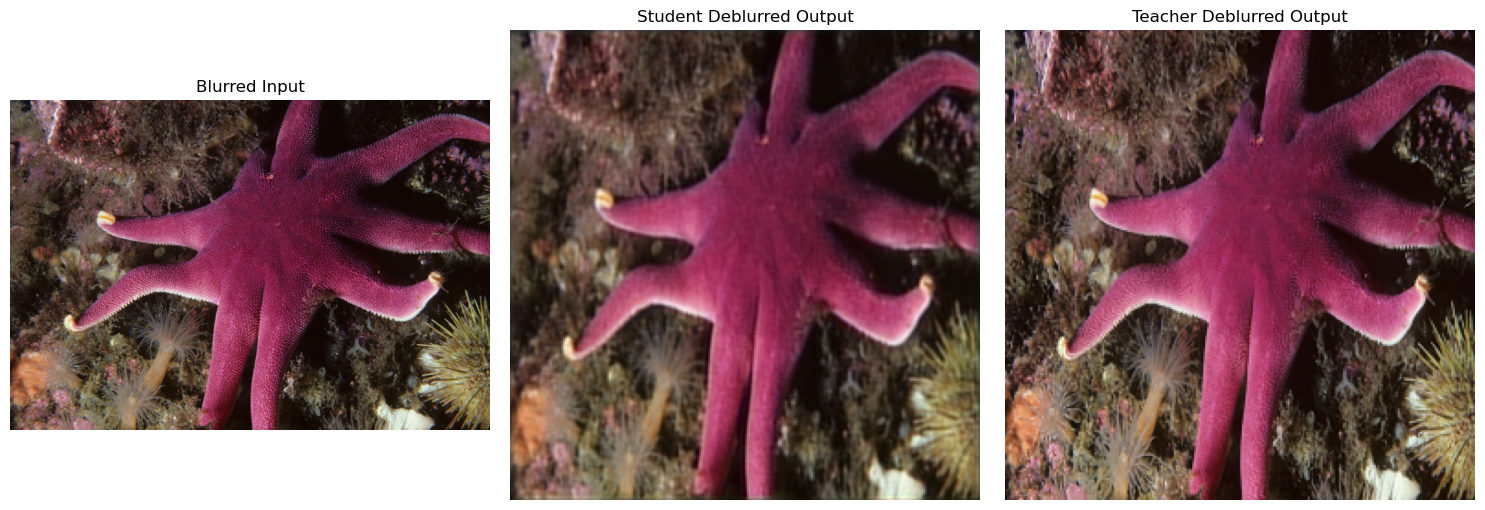

In [12]:
import matplotlib.pyplot as plt
from PIL import Image

# Load images
input_img = Image.open("0001_blurred.png")
student_output = Image.open("deblurred_student_output.png")
teacher_output = Image.open("deblurred_teacher_output.png")

# Plot
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(input_img)
plt.title("Blurred Input")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(student_output)
plt.title("Student Deblurred Output")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(teacher_output)
plt.title("Teacher Deblurred Output")
plt.axis("off")

plt.tight_layout()
plt.show()